In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from functions import windstress


In [4]:
path = '/Volumes/LaCie/Work/data/era5/DJF_1981_2023_daily_means/'

sst = xr.open_dataset(path + 'sea_surface_temperature_2010_DJF.nc')
wind = xr.open_dataset(path + 'winds_2010_DJF.nc')
sic = xr.open_dataset(path + 'sea_ice_cover_2010_DJF.nc')

shf = xr.open_dataset(path + 'sensible_heat_flux_2010_DJF.nc')
lhf = xr.open_dataset(path + 'latent_heat_flux_2010_DJF.nc')
ssr = xr.open_dataset(path + 'net_solar_radiation_2010_DJF.nc')
str = xr.open_dataset(path + 'net_thermal_radiation_2010_DJF.nc')

In [5]:
sst = sst.load()
wind = wind.load()
sic = sic.load()
shf = shf.load()
lhf = lhf.load()
ssr = ssr.load()
str = str.load()

In [ ]:
ws = xr.where(np.logical_or(sic.siconc > 0, np.isnan(sic.siconc)), np.NaN, wind)
sst = xr.where(np.logical_or(sic.siconc > 0, np.isnan(sic.siconc)), np.NaN, sst.sst)
shf = xr.where(np.logical_or(sic.siconc > 0, np.isnan(sic.siconc)), np.NaN, shf.sshf)
lhf = xr.where(np.logical_or(sic.siconc > 0, np.isnan(sic.siconc)), np.NaN, lhf.slhf)
ssr = xr.where(np.logical_or(sic.siconc > 0, np.isnan(sic.siconc)), np.NaN, ssr.ssr)
str = xr.where(np.logical_or(sic.siconc > 0, np.isnan(sic.siconc)), np.NaN, str.str)

In [7]:
# Define the dimensions
time_dim = 90
lat_dim = 201
lon_dim = 1440

# Generate latitude values (assuming they are evenly spaced from -90 to 90 degrees)
latitudes = sst['latitude'].data

# Calculate the Coriolis parameter (f) for each latitude
omega = 7.2921e-5  # Earth's angular velocity in rad/s
f = 2 * omega * np.sin(np.deg2rad(latitudes))

# Expand f to match the dimensions of the dataset (time, latitude, longitude)
f_expanded = np.tile(f, (time_dim, lon_dim, 1)).transpose(0, 2, 1)

# Print the shape of the expanded Coriolis parameter array to verify
print(f_expanded.shape)

(90, 201, 1440)


In [8]:
# Create the xarray Dataset
ds = xr.Dataset(
    {
        'f': (['time', 'latitude', 'longitude'], f_expanded),
        'u_wind': (['time', 'latitude', 'longitude'], ws.u10.data),
        'v_wind': (['time', 'latitude', 'longitude'], ws.v10.data),
        'sst': (['time', 'latitude', 'longitude'], sst.data)
    },
    coords={
        'time': sst['time'].data,
        'latitude': sst['latitude'].data,
        'longitude': sst['longitude'].data
    }
)

In [9]:
from functions import windstress

tau_x = windstress.stress(ds['u_wind'], z=10., drag='largepond', rho_air=1.22, Ta=3.)
tau_y = windstress.stress(ds['v_wind'], z=10., drag='largepond', rho_air=1.22, Ta=3.)

In [10]:
ds['tau_x'] = (('time', 'latitude', 'longitude'), tau_x)
ds['tau_y'] = (('time', 'latitude', 'longitude'), tau_y)

$$ \text{Ekman Heat Flux} = \frac{1}{\rho \cdot C_p} \left( U_E \cdot \Delta \text{SST} \right) $$

In [3]:
# Define the function to calculate Ekman heat flux
def calculate_ekman_heat_flux(ds):
    """
    Calculate Ekman heat flux using the xarray dataset with parameters f, tau_x, tau_y, and sst.
    
    Parameters:
    ds (xarray.Dataset): The input dataset containing 'f', 'tau_x', 'tau_y', and 'sst'.
    
    Returns:
    xarray.DataArray: The Ekman heat flux.
    """
    # Extract parameters from the dataset
    f = ds['f']
    tau_x = ds['tau_x']
    tau_y = ds['tau_y']
    sst = ds['sst']
    
    # Constants
    rho = 1027  # Ocean density in kg/m^3
    Cp = 3985  # Specific heat capacity of seawater in J/(kg·K)
    
    # Calculate Ekman transport components
    U_ek_x = tau_y / (rho * f)
    U_ek_y = -tau_x / (rho * f)
    
    # Calculate the gradient of SST
    dSST_dx = np.gradient(sst, axis=2)/27798
    dSST_dy = np.gradient(sst, axis=1)/27798
    
    # Calculate Ekman heat flux
    ekman_heat_flux = (Cp * rho) * (U_ek_x * dSST_dx + U_ek_y * dSST_dy)
    
    return ekman_heat_flux

In [ ]:
# Calculate Ekman flux
ekman_flux_ds = calculate_ekman_heat_flux(ds)

ds['ekman_flux'] = (('time', 'latitude', 'longitude'), ekman_flux_ds.data)

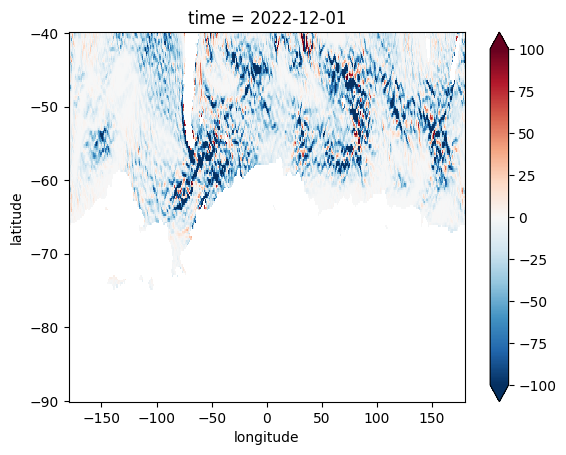

In [134]:
ekman_flux_ds.isel(time=0).plot(vmin=-100, vmax=100, cmap='RdBu_r')

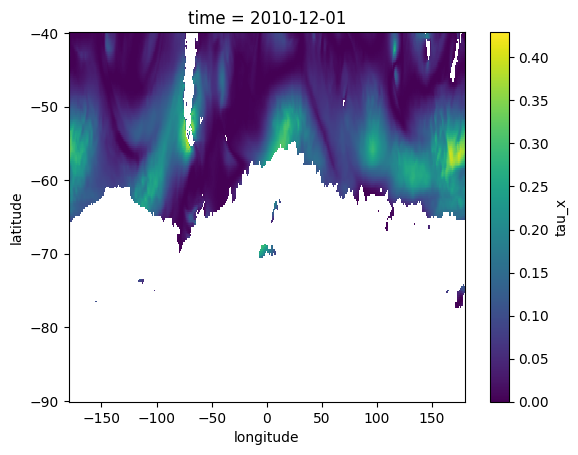

In [13]:
ds['tau_x'].isel(time=0).plot()

In [29]:
# calculate qnet

qnet = ssr + str + shf + lhf

In [30]:
mean_ek = ds['ekman_flux'].mean('time')
mean_shf = shf.mean('time')
mean_lhf = lhf.mean('time')
mean_ssr = ssr.mean('time')
mean_str = str.mean('time')
mean_qnet = qnet.mean('time')

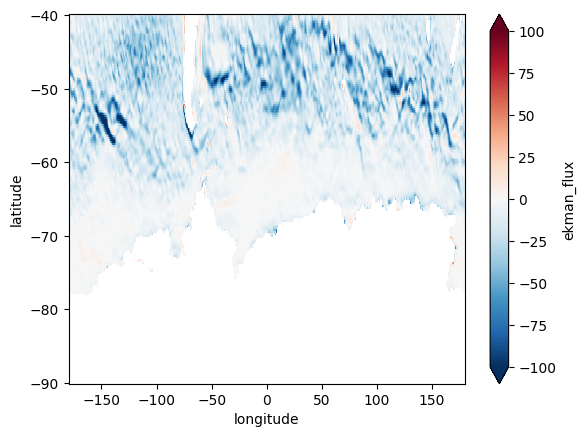

In [16]:
mean_ek.plot(vmin=-100, vmax=100, cmap='RdBu_r')

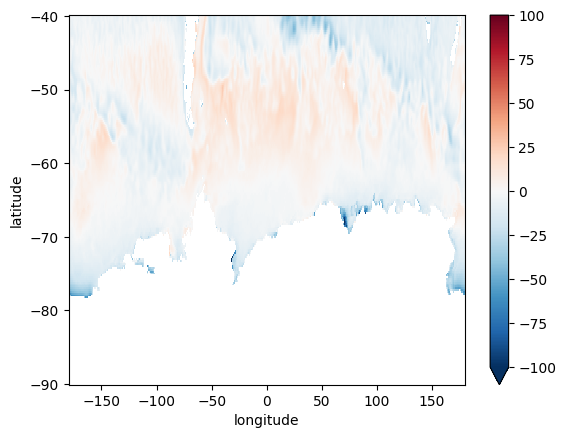

In [18]:
mean_shf.plot(vmin=-100, vmax=100, cmap='RdBu_r')

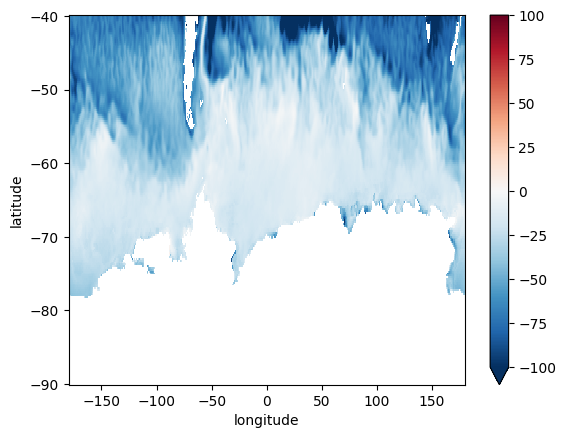

In [22]:
mean_lhf.plot(vmin=-100, vmax=100, cmap='RdBu_r')

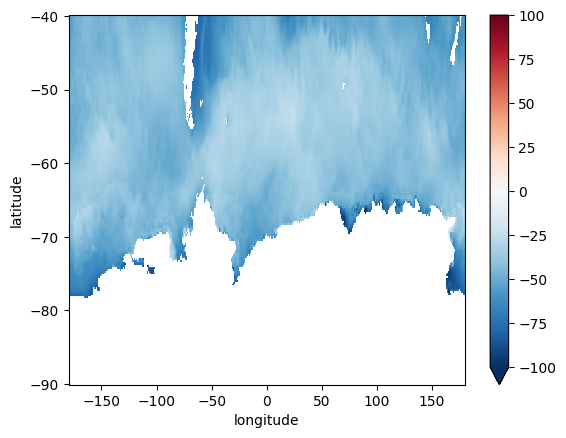

In [24]:
mean_str.plot(vmin=-100, vmax=100, cmap='RdBu_r')

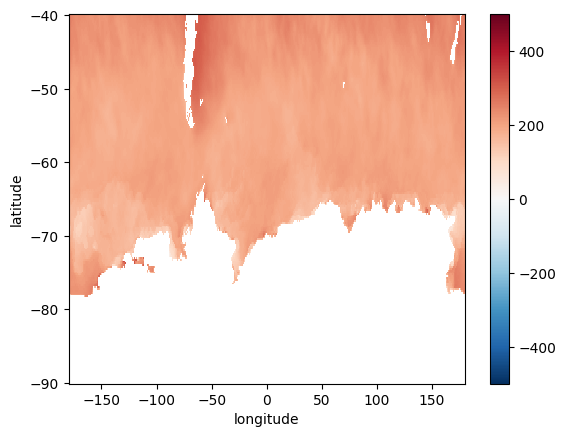

In [31]:
mean_ssr.plot(vmin=-500, vmax=500, cmap='RdBu_r')

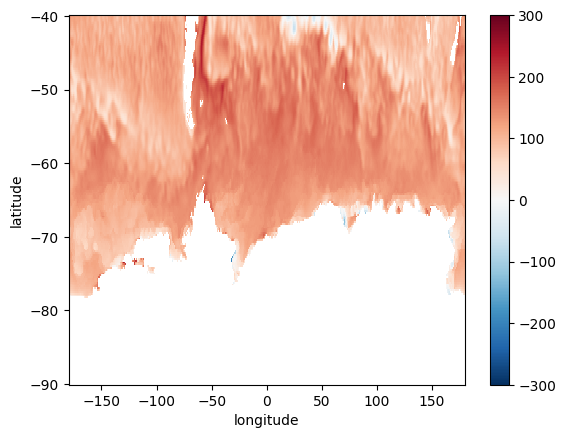

In [33]:
mean_qnet.plot(vmin=-300, vmax=300, cmap='RdBu_r')

In [41]:
mean_net_ratio = np.abs(mean_ek)/np.abs(mean_qnet)

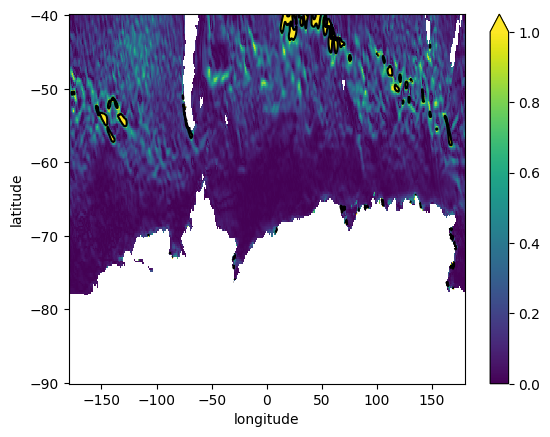

In [50]:
mean_net_ratio.plot(vmin=0, vmax=1, cmap='viridis')
mean_net_ratio.plot.contour(levels=[1], colors='k')

In [67]:
np.arange(1992,2023,1).size

31

In [6]:
from tqdm.notebook import tqdm

ratio_ek_qnet = np.ndarray([31, 201, 1440])
median_ratio = np.ndarray([31, 201, 1440])

# read in all the data as a for loop

path = '/Volumes/LaCie/Work/data/era5/DJF_1981_2023_daily_means/'

for i, year in tqdm(enumerate(np.arange(1992,2023,1))):

    year = np.array2string(year)

    # read the data in

    sst  = xr.open_dataset(path + 'sea_surface_temperature_' + year +'_DJF.nc').load()
    wind = xr.open_dataset(path + 'winds_' + year +'_DJF.nc').load()
    sic  = xr.open_dataset(path + 'sea_ice_cover_' + year +'_DJF.nc').load()
    
    shf = xr.open_dataset(path + 'sensible_heat_flux_' + year +'_DJF.nc').load()
    lhf = xr.open_dataset(path + 'latent_heat_flux_' + year +'_DJF.nc').load()
    ssr = xr.open_dataset(path + 'net_solar_radiation_' + year +'_DJF.nc').load()
    str = xr.open_dataset(path + 'net_thermal_radiation_' + year +'_DJF.nc').load()

    # take out all the regions where there is sea ice 

    ws  = xr.where(np.logical_or(sic.siconc > 0, np.isnan(sic.siconc)), np.NaN, wind)
    sst = xr.where(np.logical_or(sic.siconc > 0, np.isnan(sic.siconc)), np.NaN, sst.sst)
    shf = xr.where(np.logical_or(sic.siconc > 0, np.isnan(sic.siconc)), np.NaN, shf.sshf)
    lhf = xr.where(np.logical_or(sic.siconc > 0, np.isnan(sic.siconc)), np.NaN, lhf.slhf)
    ssr = xr.where(np.logical_or(sic.siconc > 0, np.isnan(sic.siconc)), np.NaN, ssr.ssr)
    str = xr.where(np.logical_or(sic.siconc > 0, np.isnan(sic.siconc)), np.NaN, str.str)

    # calculate the wind stress

    tau_x = windstress.stress(ws['u10'], z=10., drag='largepond', rho_air=1.22, Ta=3.)
    tau_y = windstress.stress(ws['v10'], z=10., drag='largepond', rho_air=1.22, Ta=3.)

    # Define the dimensions
    time_dim = ws.time.size
    lat_dim = ws.latitude.size
    lon_dim = ws.longitude.size
    
    # Generate latitude values (assuming they are evenly spaced from -90 to 90 degrees)
    latitudes = ws['latitude'].data
    
    # Calculate the Coriolis parameter (f) for each latitude
    omega = 7.2921e-5  # Earth's angular velocity in rad/s
    f = 2 * omega * np.sin(np.deg2rad(latitudes))
    
    # Expand f to match the dimensions of the dataset (time, latitude, longitude)
    f_expanded = np.tile(f, (time_dim, lon_dim, 1)).transpose(0, 2, 1)

    # Create the xarray Dataset
    ds = xr.Dataset(
        {
            'f': (['time', 'latitude', 'longitude'], f_expanded),
            'u_wind': (['time', 'latitude', 'longitude'], ws.u10.data),
            'v_wind': (['time', 'latitude', 'longitude'], ws.v10.data),
            'sst': (['time', 'latitude', 'longitude'], sst.data),
            'tau_x': (['time', 'latitude', 'longitude'], tau_x),
            'tau_y': (['time', 'latitude', 'longitude'], tau_y)
        },
        coords={
            'time': sst['time'].data,
            'latitude': sst['latitude'].data,
            'longitude': sst['longitude'].data
        }
    )

    # calculate Ekman flux
    ekman_flux_ds = calculate_ekman_heat_flux(ds)

    ds['ekman_flux'] = (('time', 'latitude', 'longitude'), ekman_flux_ds.data)

    # calculate qnet
    qnet = ssr + str + shf + lhf

    # calculate the ratio between the ekman flux and qnet
    ratio = np.abs(ds['ekman_flux'])/np.abs(qnet)

    # determine the median ratio for the season
    median_ratio[i] = ratio.median(dim='time')

    # calculate the mean ratio of the ekman flux to the net heat flux per season
    mean_ek = ds['ekman_flux'].mean('time').data
    mean_qnet = qnet.mean('time')

    ratio_ek_qnet[i] = np.abs(mean_ek)/np.abs(mean_qnet)



0it [00:00, ?it/s]

In [88]:
ratio_ek_qnet.shape

(31, 201, 1440)

In [7]:
# Create the xarray Dataset
ds = xr.Dataset(
    {
        'ratio_ek_qnet': (['years', 'latitude', 'longitude'], ratio_ek_qnet),
        'median_ratio': (['years', 'latitude', 'longitude'], median_ratio)
    },
    coords={
        'years': np.arange(1992,2023,1),
        'latitude': ws['latitude'].data,
        'longitude': ws['longitude'].data
    }
)

In [8]:
from functions.map_plotting import southern_ocean_map
import cartopy
import cartopy.crs as ccrs

In [9]:
# load the ACC fronts and sea ice edge locations 

import pandas as pd

sie = pd.read_csv('../../data/seaice/sie.csv').to_xarray().drop('Unnamed: 0')
fronts = pd.read_csv('../../data/fronts/ACCfronts.csv').to_xarray().drop('Unnamed: 0')

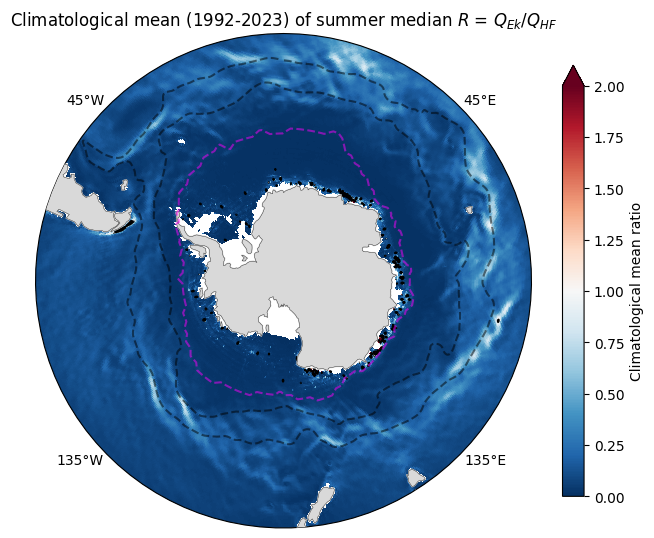

In [17]:
# plot the climatological mean of the seasonal median values of the ratio between Qek and QHF

fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(projection=ccrs.SouthPolarStereo())

ax = southern_ocean_map(ax)

plot = ds['median_ratio'].mean(dim='years').plot(cmap='RdBu_r',vmin=0, vmax=2, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.8})

colorbar = plot.colorbar
colorbar.set_label('Climatological mean ratio')
# colorbar.set_ticks([0, 20, 40, 60, 80, 100])
colorbar.ax.tick_params(labelsize=10)

# contour at R=1

ds['median_ratio'].mean(dim='years').plot.contour(levels=[1], colors='k', transform=ccrs.PlateCarree())

ax.set_title('Climatological mean (1992-2023) of summer median $R$ = $Q_{Ek}$/$Q_{HF}$')

# plot the fronts 

ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=1.5, c='k', ls='--', transform=ccrs.PlateCarree(), zorder=110, alpha=0.5)

ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=1.5, c='k', ls='--', transform=ccrs.PlateCarree(), zorder=110, alpha=0.5)

# plot the sea ice 

ax.plot(sie['si_lon'], sie['si_lat'], c='magenta', lw=1.5, ls='--', transform=ccrs.PlateCarree(), zorder=110, alpha=0.5)


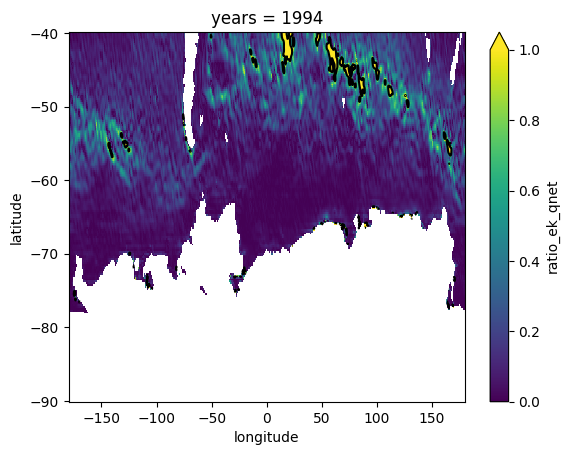

In [95]:
ds.ratio_ek_qnet[2].plot(vmin=0, vmax=1, cmap='viridis')
ds.ratio_ek_qnet[2].plot.contour(levels=[1], colors='k')

In [99]:
percentage_above_1 = (ds.ratio_ek_qnet > 1).sum(dim='years') / ds.ratio_ek_qnet.sizes['years'] * 100

In [107]:
from functions.map_plotting import southern_ocean_map
import cartopy
import cartopy.crs as ccrs

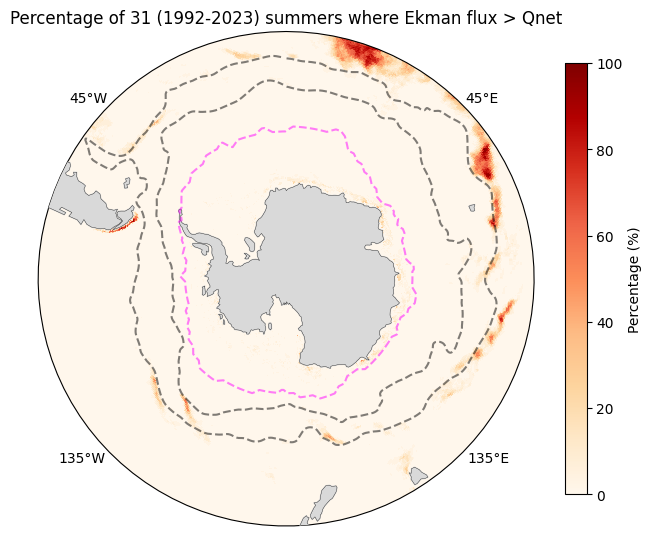

In [131]:
fig = plt.figure(figsize=(8, 7))

ax = fig.add_subplot(projection=ccrs.SouthPolarStereo())

ax = southern_ocean_map(ax)

plot = percentage_above_1.plot(cmap='OrRd',vmin=0, vmax=100, transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.8})

colorbar = plot.colorbar
colorbar.set_label('Percentage (%)')
colorbar.set_ticks([0, 20, 40, 60, 80, 100])
colorbar.ax.tick_params(labelsize=10)

ax.set_title('Percentage of 31 (1992-2023) summers where Ekman flux > Qnet')

# plot the fronts 

ax.plot(fronts['saf_lon'], fronts['saf_lat'], lw=1.5, c='k', ls='--', transform=ccrs.PlateCarree(), zorder=110, alpha=0.5)

ax.plot(fronts['pf_lon'], fronts['pf_lat'], lw=1.5, c='k', ls='--', transform=ccrs.PlateCarree(), zorder=110, alpha=0.5)

# plot the sea ice 

ax.plot(sie['si_lon'], sie['si_lat'], c='magenta', lw=1.5, ls='--', transform=ccrs.PlateCarree(), zorder=110, alpha=0.5)


In [96]:
plt.hist2d(ds.ratio_ek_qnet.data, axis=0)

TypeError: hist2d() missing 1 required positional argument: 'y'